# Loading data

In [ ]:
from scipy.io import loadmat
import pandas as pd

In [116]:
water = loadmat('OrderParam_Run06_swm4ndp_T30.0_1709121803.mat')

In [117]:
water.keys()

dict_keys(['__header__', '__version__', '__globals__', 'q_all', 'r', 'Q6_all', 'LSI_all', 'Sk_all', 'g_r'])

In [121]:
print(len(water['q_all'][0]))
print(len(water['r'][0]))
print(len(water['Q6_all'][0]))
print(len(water['LSI_all'][0]))
print(len(water['Sk_all'][0]))
print(len(water['g_r'][0]))

512
240
512
512
512
240


r and g_r has less data. I am only using q_all, Q6_all, LSI_all, Sk_all.

In [157]:
data = {'q_all': water['q_all'][0], 
        'Q6_all': water['Q6_all'][0],
        'LSI_all': water['LSI_all'][0],
        'Sk_all': water['Sk_all'][0]
        }

In [159]:
df_try = pd.DataFrame(data = data)

In [160]:
df_try.head()

q_all    Q6_all   LSI_all    Sk_all
0  0.586487  0.376439  0.000086  0.998859
1  0.614793  0.184714  0.000124  0.999004
2  0.693650  0.271328  0.001445  0.999722
3  0.627313  0.351191  0.000239  0.999468
4  0.428856  0.217197  0.000271  0.999823

# Processsing Data

In [177]:
from sklearn import preprocessing, cluster, metrics
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [178]:
# one way to normalize
x = df_try.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled= min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns = data.keys())

In [179]:
df_scaled.head()

q_all    Q6_all   LSI_all    Sk_all
0  0.620949  0.955856  0.028203  0.829094
1  0.650046  0.190639  0.044979  0.850912
2  0.731106  0.536335  0.624073  0.959202
3  0.662916  0.855085  0.095337  0.920882
4  0.458915  0.320287  0.109508  0.974402

In [180]:
# another way to normalize
df_scaled2 = scale(df_try)

In [183]:
df_scaled2[0]

array([-0.15914764,  2.41780246, -0.80589036, -0.20111769])

## PCA 

In [168]:
df_scaled.values

array([[0.62094923, 0.95585557, 0.0282031 , 0.82909437],
       [0.65004633, 0.19063877, 0.04497922, 0.85091217],
       [0.73110595, 0.53633488, 0.62407251, 0.95920161],
       ...,
       [0.84299176, 0.49193589, 0.06551929, 0.76289765],
       [0.7207142 , 0.1376308 , 0.05974383, 0.91582906],
       [0.81747075, 0.34787432, 0.00307978, 0.85780998]])

In [170]:
# Create a Randomized PCA model that takes two components
randomized_pca = PCA(n_components=2, svd_solver='randomized')

# Fit and transform the data to the model
reduced_data_rpca = randomized_pca.fit_transform(df_scaled)

# Inspect the shape
print(reduced_data_rpca.shape)

# Print out the data
print(reduced_data_rpca)

(512, 2)
[[ 0.32554586  0.32057656]
 [-0.25537562 -0.17729259]
 [ 0.17123931 -0.12704086]
 ...
 [ 0.0728137  -0.11008031]
 [-0.24162114 -0.28158036]
 [-0.04321076 -0.19942317]]


In [171]:
# Create a regular PCA model 
pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(df_scaled)

# Inspect the shape
print(reduced_data_pca.shape)

# print out data
print(reduced_data_pca)

(512, 2)
[[ 0.32554586  0.32057656]
 [-0.25537562 -0.17729259]
 [ 0.17123931 -0.12704086]
 ...
 [ 0.0728137  -0.11008031]
 [-0.24162114 -0.28158036]
 [-0.04321076 -0.19942317]]


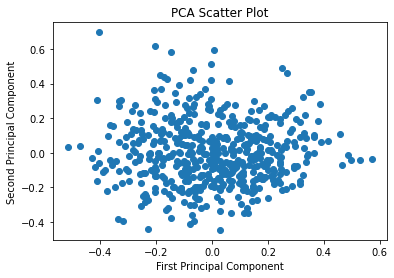

In [175]:
# Building Scatterplot to visualise data
plt.scatter(reduced_data_rpca[:, 0], reduced_data_rpca[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

There is no clear separation.

## Check the number of clusters to make with KMeans

### Elbow method
Based on the sum of squared distance (SSE)to check the best number of clusters 

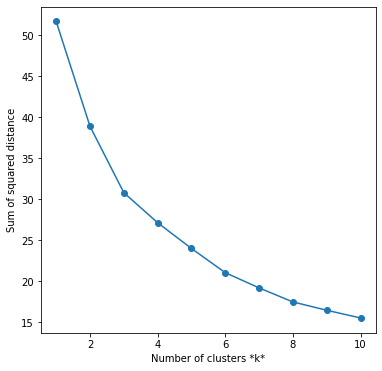

In [202]:
sse = []
list_k = list(range(1,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(df_scaled)
    sse.append(km.inertia_)
    
# Plot sse against k
plt.figure(figsize=(6,6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
    

### Silhouette Coefficient
Based on the:
a: The mean distance between a sample and all other points in the same class.
b: The mean distance between a sample and all other points in the next nearest cluster.

s = (b - a) / max(a,b)

The higher the Silhouette Coeffeicent score, the more defiend is the cluster

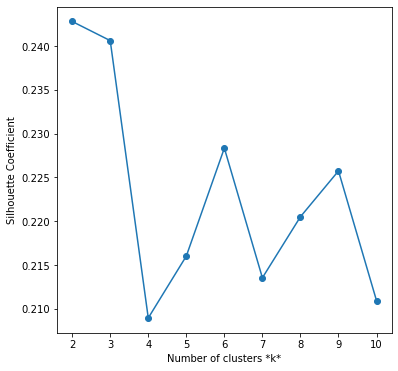

In [203]:
# md = mean distance
# minimum number of clusters is 2

md = []
list_k = list(range(2,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42).fit(df_scaled)
    labels = km.labels_
    md.append(metrics.silhouette_score(df_scaled, labels, metric='euclidean'))
    
# Plot md against k
plt.figure(figsize=(6,6))
plt.plot(list_k, md, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Coefficient');
    

### Calinski-Harabasz Index 
The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared).

also known as the Variance Ratio Criterion.

higher score = model with better defined clusters

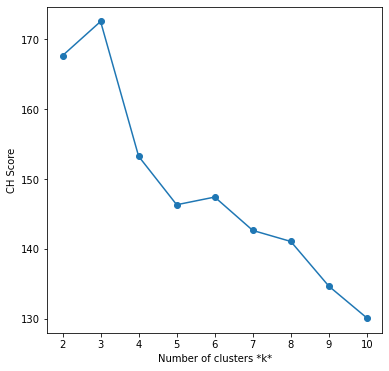

In [205]:
ch = []
list_k = list(range(2,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42).fit(df_scaled)
    labels = km.labels_
    ch.append(metrics.calinski_harabasz_score(df_scaled, labels))
    
# Plot md against k
plt.figure(figsize=(6,6))
plt.plot(list_k, ch, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('CH Score');

### Davies Bouldin Index 
This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

lower davies-Bouldin indec relates to a model with a better separation between clusters

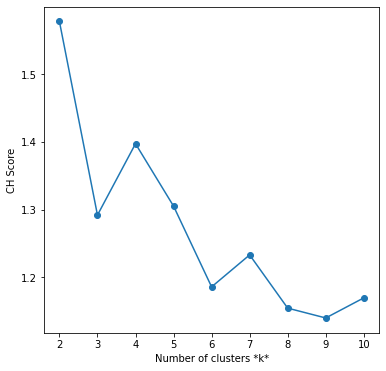

In [207]:
db = []
list_k = list(range(2,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42).fit(df_scaled)
    labels = km.labels_
    db.append(metrics.davies_bouldin_score(df_scaled, labels))
    
# Plot md against k
plt.figure(figsize=(6,6))
plt.plot(list_k, db, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('CH Score');